# Problem set 2

*26 October, 2021*
 

## Preparing the environment

In [1]:
using Pkg
cd("/Users/xkong/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps2")
Pkg.activate(".") # Create new environment in this folder

# Install dependencies
Pkg.add(["Distributions","StatsBase","DataFrames","DataFramesMeta","Chain","Plots","Random","LinearAlgebra","ShiftedArrays","CategoricalArrays","NLsolve"])

# Instantiate the current folder
Pkg.instantiate() # Updates packages given .toml file

  Activating environment at `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps2/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps2/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor-Lamadon/psets/ps2/Manifest.toml`


In [2]:
using Distributions,StatsBase,DataFrames,DataFramesMeta,Chain,Plots,Random,LinearAlgebra,ShiftedArrays,CategoricalArrays,NLsolve

global_seed = 713
Random.seed!(global_seed)

MersenneTwister(713)

## Constructing Employer-Employee Matched Data

### Step 1: Draw Firm and Worker Component

In [3]:
nk = 30     # number of firm types
nl = 10     # number of worker types

# Draw ψ, firm value V, and offer rate f jointly from a multivariate normal distribution
ψ_sd = 1.0
V_sd = 2.0
f_sd = 0.5
corr_ψV = 0.8
corr_ψf = 0.8
corr_Vf = 0.8
cov_mat = [[ψ_sd^2, corr_ψV*ψ_sd*V_sd, corr_ψf*ψ_sd*f_sd] [corr_ψV*ψ_sd*V_sd, V_sd^2, corr_Vf*V_sd*f_sd] [corr_ψf*ψ_sd*f_sd, corr_Vf*V_sd*f_sd, f_sd^2]]
d = MvNormal(cov_mat)
temp = rand(d, nk*10)
temp = sortslices(temp, dims = 2)
sim = zeros(3,nk)
for i in 1:nk
    sim[:,i] = mean(temp[:,10*(i-1)+1:10*i], dims = 2)
end 
ψ = sim[1,:]
V = sim[2,:]
expV = exp.(V)
f = exp.(sim[3,:]) ./ sum(exp.(sim[3,:]))

# Draw worker components
α_sd = 1
α = quantile.(Normal(), (1:nl) / (nl + 1)) * α_sd;

### Step 2: Construct Transition Matrix and Compute Stationary Distribution

In [4]:
# Create type-specific transition matrices
# Use joint normals centered on different values
csig  = 0.5 # cross-sectional standard deviation
csort = 0.5 # sorting effect

G = zeros(nl, nk, nk)
for l in 1:nl, k in 1:nk
    G[l, k, :] = pdf( Normal(0, csig), ψ .- csort * α[l] )
    G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
end

# Solve for the stationary distribution over psi for each alpha value
H = ones(nl, nk) ./ nk
for l in 1:nl
    M = transpose(G[l, :, :])
    for i in 1:100
        H[l, :] = M * H[l, :]
    end
end

### Step 3: Simulate a Panel

In [5]:
nt = 10     # number of periods
ni = 10000  # number of people

# Simulate a balanced panel
ii = repeat(1:ni,1,nt) # worker id
ll = repeat(rand(1:nl, ni),1,nt) # worker type
kk = zeros(Int64, ni, nt) # firm type
spell = zeros(Int64, ni, nt) # employment spell, count the number of moves

# At time 1, given worker type, draw firm type from H
for i in 1:ni
    kk[i,1] = sample(1:nk, Weights(H[ll[i,1],:]))
    # kk[i,1] = sample(1:nk, Weights(f))
end

ρ = 0.1 # death rate
λ = 0.5 # new offer rate

for t in 2:nt
    for i in 1:ni
        # First, with probability ρ, a person dies
        if rand() < ρ
            ii[i,t] = ni + ii[i,t-1] # assign a new id
            ll[i,t] = rand(1:nl) # draw a new worker type
            kk[i,t] = sample(1:nk, Weights(H[ll[i,t],:])) # draw a new firm
            # kk[i,t] = sample(1:nk, Weights(f)) # draw a new firm
            spell[i,t] = 0 # reset spell count for the new comer
        else # Second, if a person does not die, with probability λ he/she gets a new offer
            ii[i,t] = ii[i,t-1]
            ll[i,t] = ll[i,t-1]
            if rand() < λ
                new_firm = sample(1:nk, Weights(f))
                if V[kk[i,t-1]] < V[new_firm] + rand(Logistic()) # new firm has higher value
                    kk[i,t] = new_firm
                    spell[i,t] = spell[i,t-1] + 1
                else
                    kk[i,t] = kk[i,t-1]
                    spell[i,t] = spell[i,t-1]
                end
            else # Otherwise, he/she stays at the same firm
                kk[i,t] = kk[i,t-1]
                spell[i,t] = spell[i,t-1]
            end
        end
    end
end

### Step 4: Attach Firm IDs to Types

In [6]:
firms_per_type = 15
jj = zeros(Int64, ni, nt) # firm identifiers

draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

for i in 1:ni
    
    # extract firm type
    k = kk[i,1]
    # draw firm within type
    jj[i,1] = draw_firm_from_type(k)
    
    for t in 2:nt
        if ii[i,t]==ii[i,t-1] && spell[i,t]==spell[i,t-1] # if the person does not die or move
            # keep the firm the same
            jj[i,t] = jj[i,t-1]
        else
            # draw a new firm
            k = kk[i,t]
            new_j = draw_firm_from_type(k)            
            # make sure the new firm is actually new
            while new_j==jj[i,t-1]
                new_j = draw_firm_from_type(k)
            end  
            jj[i,t] = new_j
        end
    end
end

# make sure worker and firm ids are contiguous
contiguous_worker_ids = Dict( unique(ii) .=> 1:length(unique(ii)) )
ii .= getindex.(Ref(contiguous_worker_ids),ii);
contiguous_firm_ids = Dict( unique(jj) .=> 1:length(unique(jj)) )
jj .= getindex.(Ref(contiguous_firm_ids),jj);

### Step 5: Put Everything in a DataFrame

In [7]:
tt = repeat((1:nt)',ni,1)
df = DataFrame(i=ii[:], j=jj[:], t=tt[:], l=ll[:], α=α[ll[:]], k=kk[:], ψ=ψ[kk[:]], spell=spell[:], expV=expV[kk[:]], f=f[kk[:]]);
sort!(df, [:i, :t]); # sort by i, t

In [8]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

## Estimate the model

- Parameters we want to back out:
    - Firm components: $\psi$ (firm FE), $V$ (firm value), $f$ (offer distribution)
    - Worker component: $\alpha$ (worker FE)
    - Parameters: $\rho$ (death rate), $\lambda$
    - Amenity component
- Here's what we will do:
    - $\psi$ and $\alpha$: use AKM 
    - $\rho$: compute the share of new-comers every period
    - $f$: estimate using worker inflow and outflow
    - $\tilde{V}$ and $V$: estimate flow relevant value $\tilde{V}$ using equation (14) in Sorkin (2018), then use equation (13) to back out $V$ 
    - Amenity: use equation (20) to back out amenity component
- Alternatively, we can use equation (15) to back out offer distribution $f$.
    - We show that this method does not perform well since the DGP does not match Sorkin's assumptions.

### First, back out $\psi$ and $\alpha$ using AKM 

In [9]:
function AKM(df, α_hat_init, ψ_hat_init, Dmse_tol; print = 1)

    Dmse = 1
    mse0 = 1

    df[!,:α_hat] .= α_hat_init
    df[!,:ψ_hat] .= ψ_hat_init

    iter_count = 0
    while Dmse > Dmse_tol
        iter_count = iter_count + 1
        df = @chain df begin
            @transform!(:α_hat_temp = :lw .- :ψ_hat)
            groupby(:i)
            transform(:α_hat_temp => mean => :α_hat)

            @transform!(:ψ_hat_temp = :lw .- :α_hat)
            groupby(:j)
            transform(:ψ_hat_temp => mean => :ψ_hat)
        end

        mse1 = mean((df.lw .- df.α_hat .- df.ψ_hat).^2)
        Dmse = mse0 - mse1
        if print == 1
            println("Decrease in MES in iteration $iter_count is $Dmse")
        end
        mse0 = mse1
    end
    
    return df
end

Dmse_tol = 1e-9
α_hat_init = 0.0
ψ_hat_init = 0.0

df_AKM = AKM(df, α_hat_init, ψ_hat_init, Dmse_tol; print = 0)

println("Correlation between true and estimated ψ: ", round(cor(df_AKM.ψ, df_AKM.ψ_hat), digits = 3))
println("Correlation between true and estimated α: ", round(cor(df_AKM.α, df_AKM.α_hat), digits = 3))

Correlation between true and estimated ψ: 1.0
Correlation between true and estimated α: 0.994


Since we do not allow sorting here, the two-way FE estimator is unbiased.

Based on estimated $\hat{\psi}$, categorize firms into 30 groups.

In [10]:
df_AKM = @chain df_AKM begin
    groupby(:j)
    combine(:j => unique => :j, :ψ_hat => mean => :ψ_hat)
    @transform!(:firm_group = levelcode.(cut(:ψ_hat, nk)))
    select(Not(:ψ_hat))
    innerjoin(df_AKM, _ , on = :j)
end;

### Second, estimate $\rho$ by computing the share of new-comers every period


In [11]:
death_rate = @chain df_AKM begin
    groupby(:i)
    transform(:t => minimum => :t_min)
    @transform!(:new_worker = (:t_min.>1) .* (:t.==:t_min))
    groupby(:t)
    combine(:new_worker => mean => :new_worker_mean)
    @subset(:t.!=1)
    mean(_.new_worker_mean)
end

println("Estimated death rate is ", round(death_rate, digits = 3))

Estimated death rate is 0.1


In [12]:
share_movers = @chain df_AKM begin
    groupby(:i)
    transform(:j => lag => :j_lag)
    @transform!(:move = (:j .!= :j_lag) .* 1)
    transform(:move => (x -> ifelse.(ismissing.(x), 0, x)) => :move) # deal with missing values
    groupby(:t)
    combine(:move => mean => :share_movers)
    @subset(:t.!=1)
    mean(_.share_movers)
end

println("Observed share of movers per period is ", round(share_movers, digits = 3))


Observed share of movers per period is 0.21


### Third, to estimate $f$, we use worker inflow and outflow. 

Suppose a worker starts from working at firm $j$. Conditional on not dying (with probability $1-\rho$) and receiving an offer (with probability $\lambda$), he/she draws a offer (firm) from distribution $f$ firm as well as two preference shocks $\iota_j$ and $\iota_k$ distributed as Gumbel. 

The worker decides to move if $Pr(V_j + \iota_j < V_k + \iota_k)$. Since the difference between two Gumbel random variables is distributed as Logistic, denoted as $\mu$, we can derive an explicit expression for the probability.
$$ Pr(V_j < V_k + \mu) = \frac{e^{V_k}}{e^{V_j} + e^{V_k}} $$ 

We can now characterize worker inflow and outflow in two equations. Let $M_{kj}$ be the flow of workers from $j$ to $k$. Then,
$$ M_{kj} = \underbrace{g_j W}_{\text{ number of workers at j }} \underbrace{(1-\rho)}_{\text{ surviving }} \underbrace{\lambda f_k}_{\text{ getting an offer from k }} \underbrace{\frac{e^{V_k}}{e^{V_j} + e^{V_k}}}_{\text{ probability of moving }} $$

Hence, the total outflow from $j$ is given by
$$ M_{Ej} = \sum_k M_{kj} = \sum_k g_j W (1-\rho) \lambda f_k \frac{e^{V_k}}{e^{V_j} + e^{V_k}} $$
<!-- Normalizing $e^{V_1} = 1$, we have -->
<!-- $$ \frac{M_{Ej}}{M_{E1}} = \frac{g_j}{g_1} \frac{\sum_k f_k \frac{e^{V_k}}{e^{V_j} + e^{V_k}}}{\sum_{k'} f_{k'} \frac{e^{V_{k'}}}{1 + e^{V_{k'}}}} $$ -->

Similarly, the total inflow to firm $k$ is given by
$$ M_{kE} = \sum_j M_{kj} = \sum_j g_j W (1-\rho) \lambda f_k \frac{e^{V_k}}{e^{V_j} + e^{V_k}} $$
<!-- $$ \implies \frac{M_{kE}}{M_{1E}} = \frac{f_k}{f_1} \frac{\sum_j g_j\frac{e^{V_k}}{e^{V_j} + e^{V_k}}}{\sum_{j'} g_{j'} \frac{1}{e^{V_{j'}} + 1}} $$ -->

Let's start by constructing the worker flow matrix.

In [13]:
M_kj = @chain df_AKM begin
    groupby(:i)
    transform(:j => lag => :j_lag, :firm_group => lag => :firm_group_lag)
    @transform!(:move = (:j .!= :j_lag) .* 1)
    transform(:move => (x -> ifelse.(ismissing.(x), 0, x)) => :move) # deal with missing values
    @subset(:move .== 1)

    groupby([:firm_group_lag, :firm_group])
    combine(:move => sum => :num_movers)
end

M_kj_mat = zeros(Int64, nk, nk)
for i in 1:size(M_kj)[1]
    M_kj_mat[M_kj.firm_group_lag[i],M_kj.firm_group[i]] = M_kj.num_movers[i]
end

Moutflow = sum(M_kj_mat, dims = 2);
Minflow = sum(M_kj_mat, dims = 1)';

Compute total employment and employment share per firm type.

In [14]:
emp = @chain df_AKM begin
    @transform!(:n = 1)
    groupby([:firm_group])
    combine(:n => sum => :n)
    transform(:n => (x -> x ./ sum(x)) => :g)
    # select(Not(:n))
end;

Now, solve for $f$. 

The figure below shows that we can trace out offer distribution pretty well.

Note that $V$ is not identified here.

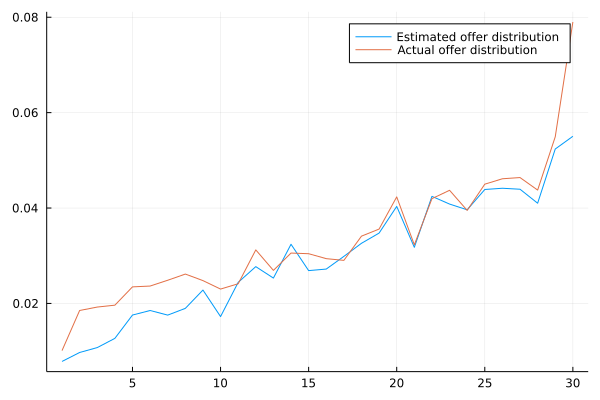

In [15]:
f_init = ones(nk,1) ./ nk;
V_init = zeros(nk,1);
x_init = [f_init; V_init];

function firm_solve(x) 
    f = x[1:nk];
    V = x[nk+1:end];
    expV = exp.(V);

    identity = sum(f) - 1;
    eqout = Moutflow .- emp.n .* (1-death_rate) .* λ .* sum(f' .* expV' ./ (expV.+expV'), dims = 2);
    eqin = Minflow .- (1-death_rate) .* λ .* f .* sum(emp.n .* expV' ./ (expV.+expV'), dims = 1)';
    return [identity; eqout; eqin[1:end-1]]
end

x_sol = nlsolve(firm_solve, x_init);
f_sol = x_sol.zero[1:nk];
V_sol = x_sol.zero[nk+1:end];

plot(1:nk, f_sol, label = "Estimated offer distribution")
plot!(1:nk, f, label = "Actual offer distribution")


### Next, estimate $\tilde{V}$ and $V$ 

Estimate flow relevant value $\tilde{V}$ using equation (14) in Sorkin (2018), then use equation (13) to back out $V$.


In [16]:
expVtilde_ratio = zeros(nk,nk)
for j in 1:nk
    for k in 1:nk
        if M_kj_mat[k,j] * M_kj_mat[j,k] != 0
            expVtilde_ratio[j,k] = M_kj_mat[k,j] / M_kj_mat[j,k]
        end
    end
end

# take log and solve a system of linear equations
Vtilde_diff = log.(expVtilde_ratio)
# since there are more equations than unknowns, variables are over-identified
# hence, use OLS to minimize MSE
X = zeros(nk*nk, nk)
Y = zeros(nk*nk, 1)
keep_obs = zeros(Int, 0)
for j in 1:nk
    for k in 1:nk
        X[(j-1)*nk+k, j] = 1
        X[(j-1)*nk+k, k] = -1
        Y[(j-1)*nk+k] = Vtilde_diff[j,k]
        if Vtilde_diff[j,k] != -Inf
            keep_obs = append!(keep_obs, (j-1)*nk+k) 
        end
    end
end

X = X[keep_obs,:]
Y = Y[keep_obs]
Vtilde_hat = inv(X'*X) * (X'*Y)
expVtilde_hat = exp.(Vtilde_hat);

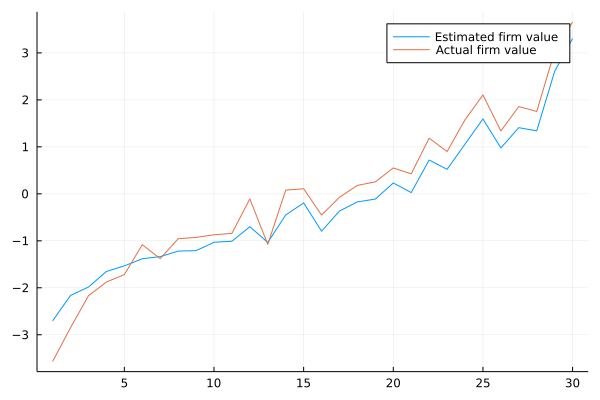

In [17]:
expV_hat = expVtilde_hat .* emp.g .* (1-death_rate) ./ f_sol
V_hat = log.(expV_hat)
cor(expV_hat, expV)

plot(1:nk, V_hat, label = "Estimated firm value")
plot!(1:nk, V, label = "Actual firm value")

### Finally, back out amenity component

Use equation (20) in Sorkin (2018)

In [18]:
firm_component = @chain df_AKM begin
    groupby(:firm_group)
    combine(:ψ_hat => mean => :ψ_hat)
end

amenity = V_hat - firm_component.ψ_hat

println("Variance of amenity component is ", round(var(amenity), digits = 3))
println("Covariance of ψ and amenity is ", round(cov(firm_component.ψ_hat, amenity), digits = 3))
println("Covariance of firm value and amenity is ", round(cov(V_hat, amenity), digits = 3))

Variance of amenity component is 0.215
Covariance of ψ and amenity is 0.364
Covariance of firm value and amenity is 0.579


### As an aside, we estimate offer distribution $f$ using equation (15) in Sorkin (2018)

As shown below, we fail to trace out offer distribution based on this method.

This is because the assumption - unemployment (new) and employment workers searching from the same distribution - fails here.

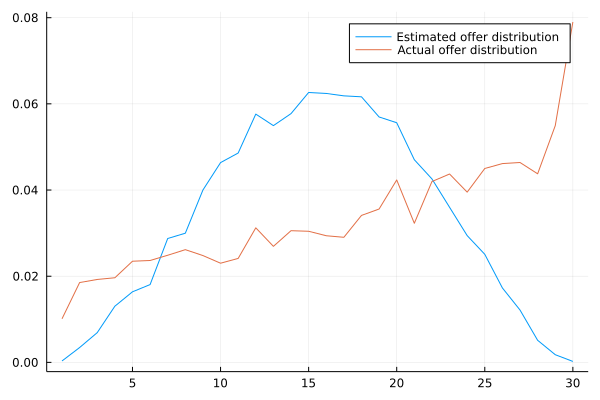

In [19]:
M_jn = @chain df_AKM begin
    groupby(:i)
    transform(:t => minimum => :t_min)
    @transform!(:new_worker = (:t_min.>1) .* (:t.==:t_min))
    @subset(:new_worker.==1)
    groupby(:firm_group)
    combine(:firm_group => unique => :firm_group, :new_worker => sum => :M_jn)
end

offer_dist = @chain M_jn begin
    transform(:M_jn => (x -> x./sum(x)) => :f0)
end

plot(offer_dist.firm_group, offer_dist.f0, label = "Estimated offer distribution")
plot!(offer_dist.firm_group, f, label = "Actual offer distribution")